# CS 5324 Lab 5: Wide and Deep Networks

For this assignment, we will be exploring the [Heart Failure Prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download) dataset. It is a collection of datasets combined into one large dataset. This dataset is composed of observations regarding patients' health traits related to the likelihood of heart failure.

This dataset was sourced from [Kaggle](https://www.kaggle.com/datasets) and consists of 918 observations.

## Team

The team consists of three members:
1. Melodie Zhu
2. Samina Faheem
3. Giancarlos Dominguez

## Dataset Preparation

Let us import our dataset.

In [1]:
# import libraies
import os
import pandas as pd
import numpy as np
import copy

In [2]:
# get dataset from csv file
data_directory = os.getcwd() + '\\data\\heart.csv'
df = pd.read_csv(data_directory)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
print("Shape of the dataset", df.shape)

print(f"\nNumber of observations in the dataset: {df.shape[0]}")
print(f"Number of features in the dataset: {df.shape[1]}")

Shape of the dataset (918, 12)

Number of observations in the dataset: 918
Number of features in the dataset: 12


Next, we will check for any duplicate observations.

In [5]:
# check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 0


Luckily, we don't have to worry about duplicate rows. Now, let us check for rows with missing values.

In [6]:
# check for missing values
print(f"\nNumber of missing values: {df.isnull().sum().sum()}")


Number of missing values: 0


None of our observations have missing values. Therefore, we don't have to worry about holes in our data.

In [7]:
df_imputed = copy.deepcopy(df)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# define vars to encode as integer    
encoders = dict()
categorical_headers = [
    'Sex',
    'ChestPainType',
    'RestingECG',
    'ExerciseAngina',
    'ST_Slope'
]

# train all encoders
for col in categorical_headers:
    df_imputed[col] = df_imputed[col].str.strip()
    
    if col == 'HeartDisease':
        tmp = LabelEncoder()
        df_imputed[col] = tmp.fit_transform(df_imputed[col])
    else:
        # integer encode strings that are features
        encoders[col] = LabelEncoder() # save the encoder
        df_imputed[col+'_int'] = encoders[col].fit_transform(df_imputed[col])

# scale numeric, continuous variables
numeric_headers = [
    "Age", 
    "RestingBP", 
    "Cholesterol",
    "MaxHR"
]

ss = StandardScaler()
df_imputed[numeric_headers] = ss.fit_transform(df_imputed[numeric_headers])

include_header =["FastingBS","Oldpeak"]
df_imputed.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_int,ChestPainType_int,RestingECG_int,ExerciseAngina_int,ST_Slope_int
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,0.0,Up,0,1,1,1,0,2
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,1.0,Flat,1,0,2,1,0,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,0.0,Up,0,1,1,2,0,2
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,1.5,Flat,1,0,0,1,1,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,0.0,Up,0,1,2,1,0,2


In [9]:
# let's start without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers+include_header

import pprint
pp = pprint.PrettyPrinter(indent=4)

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)

We will use the following 11 features:
[   'Sex_int',
    'ChestPainType_int',
    'RestingECG_int',
    'ExerciseAngina_int',
    'ST_Slope_int',
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'FastingBS',
    'Oldpeak']


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


### Defining Class Variables

| Variable Name | Datatype | Description | Values |
:------: | :------: | :------: | :------:|
| `Age` | Numerical int | How old the patient is (yrs) | NA |
| `Sex` | Categorical str | The biological gender of the patient | {**M**: Male, **F**: Female} |
| `ChestPainType` | Categorical str | The chest pain condition of the patient | {**TA**: Typical Angina, **ATA**: Atypical Angina, **NAP**: Non-Anginal Pain, **ASY**: Asymptomatic} |
| `RestingBP` | Numerical int | The resting blood pressure (mmHg) | NA |
| `Cholesterol` | Numerical int | The cholesterol level of the patient (mm/dl) | NA |
| `FastingBS` | Categorical int | The fasting blood sugar level of the patient | {**1**: if FastingBS > 120 (mg/dl), **0**: otherwise }|
| `RestingECG` | Categorical str | The resting electrocardiogram results of the patient | {**Normal**: Normal, **ST**: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), **LVH**: Showing probable or definite left ventricular hypertrophy by Estes' criteria} |
| `MaxHR` | Numerical int | The maximum heart rate recorded in the patient | NA |
| `ExerciseAngina` | Categorical str | Whether the patient has exersice-induced angina | {**Y**: Yes, **N**: No} |
| `OldPeak` | Numerical float | ST segment value of the patient | NA |
| `ST_Slope` | Categorical str | Slope of the peak exercise ST segment | {**Up**: Upsloping, **Flat**: Flat, **Down**: Downsloping} |
| `HeartDisease` | Categorical int | Whether the patient is likely to have heart failure| {**1**: Likely to have heart failure, **0**: Not likely to have heart failure }

Since all of our features are medically related to heart conditions and failure, we will not remove any features from our dataset.

### Cross Product Features

Since our dataset has 12 features, including our target feature, and we don't want our performance to suffer due to overfitting, we will create 2 cross-product features.

`Age` & `Sex`: Regarding heart failures and condition, older people are more likely to suffer heart failure. Looking only at gender, men are more at risk of having a heart faiure than women. The combination of these features would capture the effect that age and gender have on the likelihood of suffering heart failure. Therefore, we believe it is worth further exploring by combining these features into a cross product.

`Cholesterol` & `RestingBP`: Cholesterol greartly affects the likelihood of someong having a heart failure. However, the team struggled to choose whether to combine it with `RestingBP` or `FastingBS`. Both features also affect the likelihood of heart failure. However, high blood pressure is a more consistant and reliable factor in patients who have heart failure. Additionally, high blood pressure is the leading cause of heart failure in the US. High blood sugar levels can also damage nerves and blood vessels, but it is less reliable since not all people with high blood sugar levels suffer heart failure in their lifetime. Therfore, we chose to create a cross product feature from `Cholesterol` and `RestingBP`.

### Evaluation Method

### Dataset Splitting Method

For this dataset, we will split it using the stratified 10-fold cross validation. Since we only have 918 observations, we need to maximize the use of our dataset. This method will also ensure that the subsets are as evenly distributed as possible, so that our model's performance does not skew towards one class or the other.

In [11]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score

# we want to predict the X and y data as follows:
X = df_imputed[feature_columns].to_numpy()
y = df_imputed['HeartDisease'].values

num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedKFold(n_splits=num_cv_iterations)
                         
print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [12]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model

# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
#lr_clf = HessianBinaryLogisticRegression(eta=0.1,iterations=10) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]


In [13]:
# get some of the specifics of the dataset
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 918
n_features: 11
n_classes: 2


Number of instances in each class:[410 508]


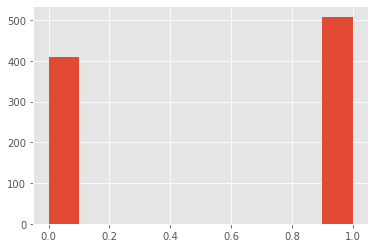

In [14]:
from matplotlib import pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('ggplot')

print('Number of instances in each class:'+str(np.bincount(y)))
plt.hist(y)
plt.show()

(0.793921568627451, 0.9411764705882353)

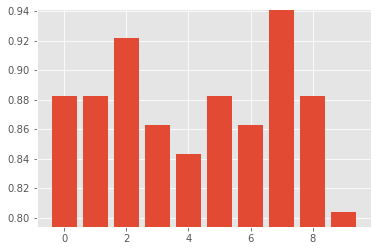

In [15]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression()
clf.fit(X,y)

#select cross validation
cv = StratifiedShuffleSplit(n_splits=10) # made kfold stratified

# select evaluation criteria
my_scorer = make_scorer(recall_score)

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])
#print(per_fold_eval_criteria.mean()*100)


# We have 508 values as 'HeartDisease' i.e. 1. From, above bar chart, we can see that few of the bars are 86% i.e. 1 denoting HeartDisease. So, some of folds have perfect recall. lowest here is 0.80, its 80% recall.
# 
# We do not have severe class imbalance in our data set. We need to stratify accross all the folds that we use and make sure classes are stratified in each fold. In order to properly seperate training and testing sets a stratified KFold should be used. Stratified KFold will ensure that each fold is representative of the overall data set. This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
# 
# - Reference : [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [16]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)


# Identifying the groups of features in the data that should be combined into cross-product features:
# 
# For this dataset, the categorical features are `Sex , ChestPainType , RestingECG, ExerciseAngina , ST_Slope`
# 
# The cross-product operation on the categorical features can be interpreted as logical conjunctions. 
# The significance of the cross-product features is creating the combined features which are more useful 
# to the prediction/classification tasks compared with the independent features .


We will use the following 11 features:
[   'Sex_int',
    'ChestPainType_int',
    'RestingECG_int',
    'ExerciseAngina_int',
    'ST_Slope_int',
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'FastingBS',
    'Oldpeak']


## Modeling

In [17]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Recall

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [18]:
# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_tensor, outputs=predictions)


In [19]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[Recall()])

model.summary()
model.fit(X_train, y_train, epochs=12, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
26/26 [==============================] - 1s 2ms/step - loss: 0.3377 - recall: 0.0742
Epoch 2/12
26/26 [==============================] - 0s 2ms/step - loss: 0.3259 - recall: 0.0939
Epo

In [22]:
import pydot_ng as pydot
import graphviz
from tensorflow.keras.utils import plot_model

In [23]:
plot_model( model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Now lets see how our model performed.

In [24]:
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

3/3 [==============================] - 0s 2ms/step
[[10 31]
 [ 9 41]]
              precision    recall  f1-score   support

           0       0.53      0.24      0.33        41
           1       0.57      0.82      0.67        50

    accuracy                           0.56        91
   macro avg       0.55      0.53      0.50        91
weighted avg       0.55      0.56      0.52        91



In [25]:
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.accuracy_score(y_test,yhat))

3/3 [==============================] - 0s 0s/step
0.5604395604395604


It is medical dataset, so it is necessary that we account for the true positives and false negatives. Predicting false negative values will be considered bad model. Hence, Recall should be used instead of accuracy due to the importance of false negatives for this data set.

### First Combination

In order to add one-hot encoding, we need to separate the categorical features that are currently saved as integers and place them into Embedding layers. An embedding layer deals with integers as if they were one-hot encoded.

In [26]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate

# start by getting only the categorical variables
# these matrices are all integers
#X_train = df_train[categorical_headers_ints].to_numpy() 
#X_test = df_test[categorical_headers_ints].to_numpy() 

embed_branches = []
all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categircal variables
input_branch = Input(shape=(X_train.shape[1],), 
                     dtype='int64', 
                     name='categorical')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = df_imputed[col].max()+1 
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

model = Model(inputs=input_branch, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[Recall()])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical (InputLayer)       [(None, 11)]         0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None,)             0           ['categorical[0][0]']            
 a)                                                                                               
                                                                                                  
 tf.compat.v1.gather_1 (TFOpLam  (None,)             0           ['categorical[0][0]']            
 bda)                                                                                             
                                                                                            

In [27]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)

Epoch 1/10
17/17 [==============================] - 1s 4ms/step - loss: 0.2533 - recall_1: 0.0000e+00
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.2504 - recall_1: 0.0546
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.2475 - recall_1: 0.3865
Epoch 4/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2447 - recall_1: 0.7860
Epoch 5/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2421 - recall_1: 0.8930
Epoch 6/10
17/17 [==============================] - 0s 4ms/step - loss: 0.2396 - recall_1: 0.9039
Epoch 7/10
17/17 [==============================] - 0s 3ms/step - loss: 0.2371 - recall_1: 0.9585
Epoch 8/10
17/17 [==============================] - 0s 5ms/step - loss: 0.2347 - recall_1: 0.9607
Epoch 9/10
17/17 [==============================] - 0s 5ms/step - loss: 0.2323 - recall_1: 0.9629
Epoch 10/10
17/17 [==============================] - 0s 4ms/step - loss: 0.2301 - recall_1: 0.9629


In [29]:
yhat_proba = model.predict(X_test)
yhat1 = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat1))
print(mt.classification_report(y_test,yhat1))

3/3 [==============================] - 0s 4ms/step
[[26 15]
 [ 3 47]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        41
           1       0.76      0.94      0.84        50

    accuracy                           0.80        91
   macro avg       0.83      0.79      0.79        91
weighted avg       0.82      0.80      0.80        91



In [30]:
print(mt.accuracy_score(y_test,yhat))

0.5604395604395604


### Second Combination

In [31]:
cat_X = df_imputed[categorical_headers_ints].to_numpy()
# we want to predict the X and y data as follows:
cat_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cat_X,cat_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_cat = cat_X[train_indices]
    y_train_cat = cat_y[train_indices]
    
    X_test_cat = cat_X[test_indices]
    y_test_cat = cat_y[test_indices]
    
num_X = df_imputed[categorical_headers_ints].to_numpy()
# we want to predict the X and y data as follows:
num_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(num_X,num_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_num = num_X[train_indices]
    y_train_num = num_y[train_indices]
    
    X_test_num = num_X[test_indices]
    y_test_num = num_y[test_indices]


In [32]:
# save categorical features
#X_train_cat = df_train[categorical_headers_ints].to_numpy() 
#X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
#X_train_num =  df_[numeric_headers].to_numpy()
#X_test_num = df_test[numeric_headers].to_numpy()

all_branch_outputs = [] # this is where we will keep track of output of each branch

input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_branch_outputs.append(x)
    
# HERE IS THE ADDING OF AN INPUT USING NUMERIC DATA
# create dense input branch for numeric
inputs_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu', name='num_1')(inputs_num)
    
all_branch_outputs.append(x_dense)

# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=10, activation='relu', name='combined_1')(final_branch)
final_branch = Dense(units=1, activation='sigmoid', name='combined_2')(final_branch)

model = Model(inputs=[input_cat,inputs_num], outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[Recall()])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 tf.compat.v1.gather_5 (TFOpLam  (None,)             0           ['categorical[0][0]']            
 bda)                                                                                             
                                                                                                  
 tf.compat.v1.gather_6 (TFOpLam  (None,)             0           ['categorical[0][0]']            
 bda)                                                                                             
                                                                                            

In [33]:

plot_model(model, 
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='LR',
           expand_nested=False, 
           dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=Recall())

model.fit([ X_train_cat, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=50, 
          verbose=1)

yhat2 = model.predict([X_test_cat,
                      X_test_num]) # each branch has an input

yhat2 = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat2))
print(mt.classification_report(y_test,yhat2))

Epoch 1/10
17/17 [==============================] - 1s 3ms/step - loss: 0.2563 - recall_3: 0.7969
Epoch 2/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2542 - recall_3: 0.8166
Epoch 3/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2521 - recall_3: 0.8930
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.2500 - recall_3: 0.8690
Epoch 5/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2480 - recall_3: 0.8777
Epoch 6/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2460 - recall_3: 0.9236
Epoch 7/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2440 - recall_3: 0.9061
Epoch 8/10
17/17 [==============================] - 0s 3ms/step - loss: 0.2422 - recall_3: 0.8886
Epoch 9/10
17/17 [==============================] - 0s 2ms/step - loss: 0.2403 - recall_3: 0.8865
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
[[10 31]
 [ 9 41]]
              precision    recall  f

In [35]:
print(mt.accuracy_score(y_test,yhat2))

0.5604395604395604


### Third Combination

In [36]:
cross_columns = [['ChestPainType','RestingECG','ST_Slope'],
                 #['sex', 'marital_status'],
                 #['workclass','occupation'],
                 #['occupation','race','education'],
                 ['Sex','ExerciseAngina']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_imputed[cols_list].apply(lambda x: '_'.join(x), axis=1)
   # X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_imputed[cross_col_name] = enc.transform(X_crossed_train)
    #df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['ChestPainType_RestingECG_ST_Slope', 'Sex_ExerciseAngina']

In [37]:
cross_X = df_imputed[cross_col_df_names].to_numpy()
# we want to predict the X and y data as follows:
cross_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cross_X,cross_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_crossed = cross_X[train_indices]
    y_train_crossed = cross_y[train_indices]
    
    X_test_crossed = cross_X[test_indices]
    y_test_crossed = cross_y[test_indices]



In [38]:
# get crossed columns
#X_train_crossed = df_train[cross_col_df_names].to_numpy()
#X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
#X_train_cat = df_train[categorical_headers_ints].to_numpy() 
#X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
#X_train_num =  df_train[numeric_headers].to_numpy()
#X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)


In [39]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)
# model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [40]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['Recall'])


In [41]:
# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))


Epoch 1/15
26/26 [==============================] - 2s 16ms/step - loss: 0.2498 - recall: 0.0087 - val_loss: 0.2493 - val_recall: 0.0400
Epoch 2/15
26/26 [==============================] - 0s 4ms/step - loss: 0.2471 - recall: 0.1769 - val_loss: 0.2479 - val_recall: 0.1800
Epoch 3/15
26/26 [==============================] - 0s 4ms/step - loss: 0.2451 - recall: 0.2904 - val_loss: 0.2465 - val_recall: 0.2400
Epoch 4/15
26/26 [==============================] - 0s 4ms/step - loss: 0.2432 - recall: 0.4148 - val_loss: 0.2452 - val_recall: 0.3000
Epoch 5/15
26/26 [==============================] - 0s 4ms/step - loss: 0.2416 - recall: 0.4956 - val_loss: 0.2440 - val_recall: 0.3400
Epoch 6/15
26/26 [==============================] - 0s 5ms/step - loss: 0.2400 - recall: 0.5306 - val_loss: 0.2429 - val_recall: 0.3400
Epoch 7/15
26/26 [==============================] - 0s 5ms/step - loss: 0.2385 - recall: 0.5371 - val_loss: 0.2418 - val_recall: 0.3400
Epoch 8/15
26/26 [=============================

In [42]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

3/3 [==============================] - 0s 4ms/step
[[32  9]
 [17 33]]
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        41
           1       0.79      0.66      0.72        50

    accuracy                           0.71        91
   macro avg       0.72      0.72      0.71        91
weighted avg       0.73      0.71      0.71        91



## Graduate Analysis